## Speech Enhancement Algorithm based on Tensorflow and Keras




# Imports

In [1]:
!pip install pypesq

  Preparing metadata (setup.py) ... done
  Created wheel for pypesq: filename=pypesq-1.2.4-cp37-cp37m-linux_x86_64.whl size=115834 sha256=54a5903d07669f02b362cf27e7c6c8c8829e42dbfbd6847fe36249c8c7ed25b0
  Stored in directory: /root/.cache/pip/wheels/48/b5/16/d9a8d51220781689bf670dfcb9ccfdabf45ef26168b052b139
Successfully built pypesq


In [2]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow_io as tfio
import keras
from keras.models import Sequential
import tensorflow_io as tfio
import warnings
import glob
from keras.callbacks import ModelCheckpoint
from pypesq import pesq
import soundfile as sf

# Load Data and Preprocess

In [3]:
sr=8000
speech_length_pix_sec=27e-3
total_length = 3.6
trim_length = 28305
n_fft=255
frame_length=255
frame_step = 110

noisefiles = glob.glob('/kaggle/input/urban-sound-8k/**/*.wav')
files= glob.glob('/kaggle/input/ravdess-8k/**/*.wav')
print(len(files),'clean data files')
print('Should be similar value to trim length', total_length*sr,trim_length)
print('Should be similar value to n_fft',n_fft, int(speech_length_pix_sec*sr))

@tf.function
def load_wav(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
#     sample_rate = tf.cast(sample_rate, dtype=tf.int64)
#     wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=sr)
    return wav

@tf.function
def preprocess_tf(filepath):
    wav = load_wav(filepath)
    wav = wav[:trim_length]
    zero_padding = tf.zeros([trim_length] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    return wav

@tf.function
def white_noise(data,factor=0.03):
    noise_amp = factor*tf.reduce_max(data)*tf.random.normal(shape=(1,))
    corr_data = data + noise_amp*tf.random.normal(shape=tf.shape(data))
    return corr_data, data

@tf.function
def urban_noise(corr_data, data, factor=0.4,sr=sr):
    noisefile = tf.gather(noisefiles,tf.random.uniform((),0, len(noisefiles)-1,dtype=tf.int32))
    noisefile  = load_wav(noisefile)
    mixed = noisefile * factor * tf.reduce_max(corr_data)/tf.reduce_max(noisefile) + corr_data 
    return mixed, data

@tf.function
def convert_to_spectrogram(wav_corr, wavclean):
    spectrogram_corr = tf.signal.stft(wav_corr, frame_length=frame_length, fft_length=n_fft,
                                      frame_step=frame_step)
    spectrogram = tf.signal.stft(wavclean, frame_length=frame_length, fft_length=n_fft,
                                      frame_step=frame_step)
    return spectrogram_corr, spectrogram

@tf.function
def spectrogram_abs(spectrogram_corr, spectrogram):
    spectrogram = tf.abs(spectrogram)
    spectrogram_corr = tf.abs(spectrogram_corr)
    return spectrogram_corr, spectrogram

@tf.function
def augment(spectrogram_corr, spectrogram):
    spectrogram_corr = tfio.audio.freq_mask(spectrogram_corr, 10)
    spectrogram_corr = tfio.audio.time_mask(spectrogram_corr, 20)
    return spectrogram_corr, spectrogram

@tf.function
def expand_dims(spectrogram_corr, spectrogram):
    spectrogram_corr = tf.expand_dims(spectrogram_corr, axis=2)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram_corr, spectrogram

1440 clean data files
Should be similar value to trim length 28800.0 28305
Should be similar value to n_fft 255 216


In [4]:
batch_size=16
train_val_split_ratio = 0.2
split_index = int(len(files)*train_val_split_ratio)
train_files = files[split_index:]
val_files = files[:split_index]

def configure_dataset(files, train=True):
    dataset = tf.data.Dataset.from_tensor_slices(files)
    dataset = dataset.map(load_wav, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(white_noise, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(urban_noise, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(convert_to_spectrogram, num_parallel_calls=tf.data.AUTOTUNE)
    if not train:
        dataset = dataset.map(expand_dims, num_parallel_calls=tf.data.AUTOTUNE)

    if train:
        dataset = dataset.map(spectrogram_abs, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.map(expand_dims, num_parallel_calls=tf.data.AUTOTUNE)
        
        dataset = dataset.batch(batch_size)
        dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset
train_dataset = configure_dataset(train_files)
val_dataset = configure_dataset(val_files)

# Create and Run Model

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Conv2DTranspose,
    MaxPooling2D,
    Dropout,
    SpatialDropout2D,
    UpSampling2D,
    Input,
    concatenate,
    multiply,
    add,
    Activation,
)


def upsample_conv(filters, kernel_size, strides, padding):
    return Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)


def upsample_simple(filters, kernel_size, strides, padding):
    return UpSampling2D(strides)


def attention_gate(inp_1, inp_2, n_intermediate_filters):
    """Attention gate. Compresses both inputs to n_intermediate_filters filters before processing.
       Implemented as proposed by Oktay et al. in their Attention U-net, see: https://arxiv.org/abs/1804.03999.
    """
    inp_1_conv = Conv2D(
        n_intermediate_filters,
        kernel_size=1,
        strides=1,
        padding="same",
        kernel_initializer="he_normal",
    )(inp_1)
    inp_2_conv = Conv2D(
        n_intermediate_filters,
        kernel_size=1,
        strides=1,
        padding="same",
        kernel_initializer="he_normal",
    )(inp_2)

    f = Activation("relu")(add([inp_1_conv, inp_2_conv]))
    g = Conv2D(
        filters=1,
        kernel_size=1,
        strides=1,
        padding="same",
        kernel_initializer="he_normal",
    )(f)
    h = Activation("sigmoid")(g)
    return multiply([inp_1, h])


def attention_concat(conv_below, skip_connection):
    """Performs concatenation of upsampled conv_below with attention gated version of skip-connection
    """
    below_filters = conv_below.get_shape().as_list()[-1]
    attention_across = attention_gate(skip_connection, conv_below, below_filters)
    return concatenate([conv_below, attention_across])


def conv2d_block(
    inputs,
    use_batch_norm=True,
    dropout=0.3,
    dropout_type="spatial",
    filters=16,
    kernel_size=(3, 3),
    activation="relu",
    kernel_initializer="he_normal",
    padding="same",
):

    if dropout_type == "spatial":
        DO = SpatialDropout2D
    elif dropout_type == "standard":
        DO = Dropout
    else:
        raise ValueError(
            f"dropout_type must be one of ['spatial', 'standard'], got {dropout_type}"
        )

    c = Conv2D(
        filters,
        kernel_size,
        activation=activation,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=not use_batch_norm,
    )(inputs)
    if use_batch_norm:
        c = BatchNormalization()(c)
    if dropout > 0.0:
        c = DO(dropout)(c)
    c = Conv2D(
        filters,
        kernel_size,
        activation=activation,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=not use_batch_norm,
    )(c)
    if use_batch_norm:
        c = BatchNormalization()(c)
    return c


def custom_unet(
    input_shape,
    num_classes=1,
    activation="relu",
    use_batch_norm=True,
    upsample_mode="deconv",  # 'deconv' or 'simple'
    dropout=0.3,
    dropout_change_per_layer=0.0,
    dropout_type="spatial",
    use_dropout_on_upsampling=False,
    use_attention=False,
    filters=16,
    num_layers=4,
    output_activation="sigmoid",
):  # 'sigmoid' or 'softmax'

    if upsample_mode == "deconv":
        upsample = upsample_conv
    else:
        upsample = upsample_simple

    # Build U-Net model
    inputs = Input(input_shape)
    inputs_copy = tf.identity(inputs)
    x = inputs / tf.reduce_max(inputs)

    down_layers = []
    for l in range(num_layers):
        x = conv2d_block(
            inputs=x,
            filters=filters,
            use_batch_norm=use_batch_norm,
            dropout=dropout,
            dropout_type=dropout_type,
            activation=activation,
        )
        down_layers.append(x)
        x = MaxPooling2D((2, 2))(x)
        dropout += dropout_change_per_layer
        filters = filters * 2  # double the number of filters with each layer

    x = conv2d_block(
        inputs=x,
        filters=filters,
        use_batch_norm=use_batch_norm,
        dropout=dropout,
        dropout_type=dropout_type,
        activation=activation,
    )

    if not use_dropout_on_upsampling:
        dropout = 0.0
        dropout_change_per_layer = 0.0

    for conv in reversed(down_layers):
        filters //= 2  # decreasing number of filters with each layer
        dropout -= dropout_change_per_layer
        x = upsample(filters, (2, 2), strides=(2, 2), padding="same")(x)
        if use_attention:
            x = attention_concat(conv_below=x, skip_connection=conv)
        else:
            x = concatenate([x, conv])
        x = conv2d_block(
            inputs=x,
            filters=filters,
            use_batch_norm=use_batch_norm,
            dropout=dropout,
            dropout_type=dropout_type,
            activation=activation,
        )

    output_mask = Conv2D(num_classes, (1, 1), activation=output_activation)(x)
    outputs = keras.layers.Multiply()([output_mask, inputs_copy])
    model = Model(inputs=[inputs], outputs=[outputs])
    return model


In [6]:
model = custom_unet(
    input_shape=(256, 128, 1),
    use_batch_norm=True,
    num_classes=1,
    filters=16, 
    num_layers=4,
    dropout=0.2,
    output_activation='sigmoid')

model_filename = 'model_weights.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss',
    save_weights_only=True,
    save_best_only=True)

callback_early_stop =tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=4,
    mode="auto",
    restore_best_weights=True,
)

def signal_enhancement_loss(y_true, y_pred):
    mae = tf.abs(y_true - y_pred)
    speech_loss =  2 * tf.abs(y_true**2 - y_pred*y_true)
    return tf.reduce_mean(mae, axis=-1) + tf.reduce_mean(speech_loss, axis=-1) # Note the `axis=-1`

model.compile(optimizer='adam', loss=signal_enhancement_loss)
model.load_weights('/kaggle/input/speech-mask-model/model_weights_custom_loss2.h5')

In [7]:
# keras.utils.vis_utils.plot_model(model,show_shapes=True)

# Run Model 


In [8]:
 history = model.fit(train_dataset,epochs=30,shuffle=True, validation_data=val_dataset,
                     callbacks=[callback_checkpoint, callback_early_stop])

# Inspect Results

In [9]:
trim_length = 28305
files_to_test = val_files
test_dataset = configure_dataset(files_to_test,train=False)
num = test_dataset.as_numpy_iterator()
mae = tf.keras.losses.MeanAbsoluteError()
pesq_with_noise = np.zeros(len(files_to_test))
pesq_denoised = np.zeros(len(files_to_test))

wav_clean_array =  np.zeros((len(files_to_test),trim_length))
wav_corrupt_array =  np.zeros((len(files_to_test),trim_length))
wav_correct_array =  np.zeros((len(files_to_test),trim_length))
spec_clean_array=  np.zeros((len(files_to_test), 256, 128))
spec_corrupt_array=  np.zeros((len(files_to_test), 256, 128))
spec_correct_array=  np.zeros((len(files_to_test), 256, 128))
loss_with_noise = np.zeros(len(files_to_test))
loss_denoised = np.zeros(len(files_to_test))


for ind in range(len(files_to_test)):
    corr, clean = num.next()
    corr_wav = tf.signal.inverse_stft(corr[:,:,0], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)
    clean_wav = tf.signal.inverse_stft(clean[:,:,0], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)
    corr_amp = np.abs(corr)
    corrected_amp = model.predict(np.expand_dims(corr_amp,0))
    corrected_spec = corrected_amp * np.exp(1j*np.angle(np.expand_dims(corr,0)))
    corrected_wav = tf.signal.inverse_stft(corrected_spec[0,:,:,0], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step) 
     
    pesq_with_noise[ind] = pesq(clean_wav,corr_wav,sr)
    pesq_denoised[ind] = pesq(clean_wav,corrected_wav,sr)
    wav_clean_array[ind] = clean_wav
    wav_corrupt_array[ind] = corr_wav
    wav_correct_array[ind] = corrected_wav
    spec_clean_array[ind] = np.abs(clean[:,:,0])
    spec_corrupt_array[ind] = np.abs(corr[:,:,0])
    spec_correct_array[ind] = corrected_amp[0,:,:,0]
    loss_with_noise[ind] = tf.reduce_mean(signal_enhancement_loss(np.abs(clean), corr_amp)).numpy()
    loss_denoised[ind] =tf.reduce_mean(signal_enhancement_loss(np.abs(clean[:,:,0]), corrected_amp[0,:,:,0])).numpy()

pesq_diff = pesq_denoised - pesq_with_noise

print(np.mean(pesq_with_noise), np.mean(pesq_denoised),pesq_diff.mean())

f'{np.mean(pesq_with_noise):.2f}, {np.mean(pesq_denoised):.2f}'

2.0848689778811402 2.5309171420004635 0.4460481641193231


'2.08, 2.53'

In [10]:
os.system('rm -r val_results')

rm: cannot remove 'val_results': No such file or directory


256

In [11]:
results_dir = 'val_results'
os.mkdir(results_dir)

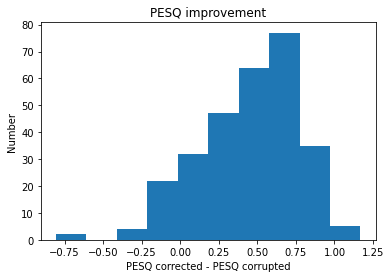

In [12]:
fig = plt.figure()
plt.title('PESQ improvement')
plt.hist(pesq_diff);
plt.xlabel('PESQ corrected - PESQ corrupted')
plt.ylabel('Number')
fig.savefig(results_dir+'/pesq_hist', bbox_inches='tight')

In [13]:
ind=np.where(pesq_diff==pesq_diff.max())[0][0]
sf.write(results_dir +'/'+'clean_best_pesq_improvement.wav',wav_clean_array[ind],sr)
sf.write(results_dir +'/'+'corrupt_best_pesq_improvement.wav',wav_corrupt_array[ind],sr)
sf.write(results_dir +'/'+'correct_best_pesq_improvement.wav',wav_correct_array[ind],sr)

In [14]:
Audio(wav_clean_array[ind],rate=sr)

In [15]:
Audio(wav_corrupt_array[ind],rate=sr)

In [16]:
Audio(wav_correct_array[ind],rate=sr)

In [17]:
ind=np.where(pesq_diff==pesq_diff.min())[0][0]
sf.write(results_dir +'/'+'clean_worst_pesq_improvement.wav',wav_clean_array[ind],sr)
sf.write(results_dir +'/'+'corrupt_worst_pesq_improvement.wav',wav_corrupt_array[ind],sr)
sf.write(results_dir +'/'+'correct_worst_pesq_improvement.wav',wav_correct_array[ind],sr)

In [18]:
Audio(wav_clean_array[ind],rate=sr)

In [19]:
Audio(wav_corrupt_array[ind],rate=sr)

In [20]:
Audio(wav_correct_array[ind],rate=sr)

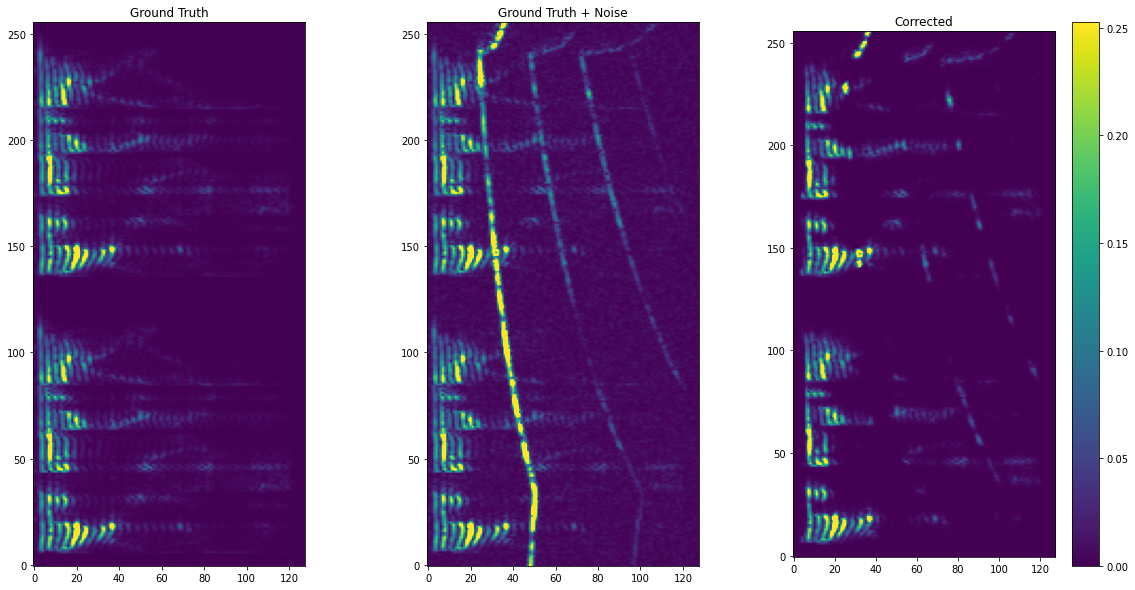

In [21]:
ind=np.where(pesq_diff==pesq_diff.max())[0][0]
fig,axes = plt.subplots(ncols=3,figsize=(20,10))
vmax=spec_clean_array[ind].max()/3
vmin=0
plt.subplot(1,3,1)
plt.title('Ground Truth')
plt.imshow(spec_clean_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.subplot(1,3,2)
plt.title('Ground Truth + Noise')
plt.imshow(spec_corrupt_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.subplot(1,3,3)
plt.title('Corrected')
plt.imshow(spec_correct_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.colorbar()
fig.savefig(results_dir+'/best_spec.png', bbox_inches='tight')

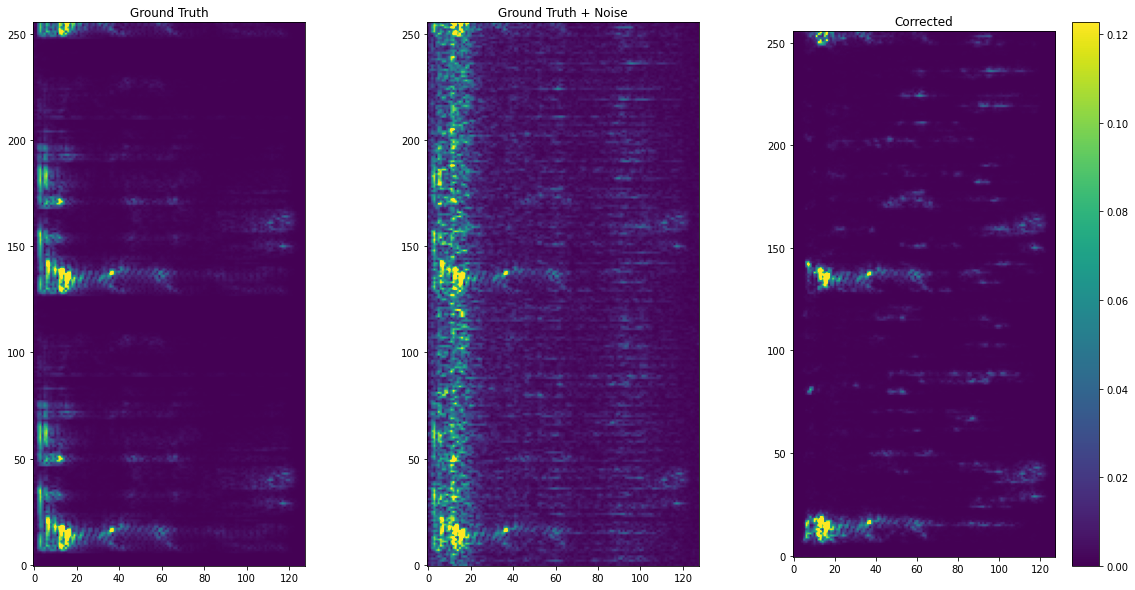

In [22]:
ind=np.where(pesq_diff==pesq_diff.min())[0][0]
fig,axes = plt.subplots(ncols=3,figsize=(20,10))
vmax=spec_clean_array[ind].max()/3
vmin=0
plt.subplot(1,3,1)
plt.title('Ground Truth')
plt.imshow(spec_clean_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.subplot(1,3,2)
plt.title('Ground Truth + Noise')
plt.imshow(spec_corrupt_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.subplot(1,3,3)
plt.title('Corrected')
plt.imshow(spec_correct_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.colorbar()
fig.savefig(results_dir+'/worst_spec.png', bbox_inches='tight')

In [23]:
test_ = np.expand_dims(corr_amp,0)

In [24]:
%%timeit -n 50
test = model.predict(test_)

38.3 ms ± 920 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [25]:
os.system(f'tar -cvzf train_val_results.tar.gz {results_dir}')

val_results/
val_results/correct_best_pesq_improvement.wav
val_results/clean_best_pesq_improvement.wav
val_results/worst_spec.png
val_results/corrupt_best_pesq_improvement.wav
val_results/pesq_hist.png
val_results/correct_worst_pesq_improvement.wav
val_results/clean_worst_pesq_improvement.wav
val_results/best_spec.png
val_results/corrupt_worst_pesq_improvement.wav


0